In [1]:
import sys
!conda install --yes --prefix {sys.prefix} scikit-image
!pip install matplotlib

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.1
  latest version: 4.9.0

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.

You should consider upgrading via the '/anaconda3/bin/python -m pip install --upgrade pip' command.


In [2]:
import skimage
import skimage.feature
import skimage.viewer
import sys
import matplotlib.pyplot as plt
from skimage import filters
from skimage.filters import threshold_mean
from skimage.filters import threshold_minimum

filename = 'images.jpeg'
#filename = 'axeillus.jpg'

# load and display original image as grayscale
image = skimage.io.imread(fname=filename, as_gray=True)


/anaconda3/envs/vivarium_env/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Viewer requires Qt
  This is separate from the ipykernel package so we can avoid doing imports until


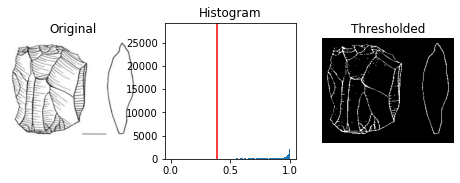

In [14]:
thresh = threshold_minimum(image)
#thresh = threshold_mean(image)

binary = image < thresh + thresh*0.2
#binary = image < thresh 

fig, axes = plt.subplots(ncols=3, figsize=(8, 2.5))
ax = axes.ravel()
ax[0] = plt.subplot(1, 3, 1)
ax[1] = plt.subplot(1, 3, 2)
ax[2] = plt.subplot(1, 3, 3, sharex=ax[0], sharey=ax[0])

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Original')
ax[0].axis('off')

ax[1].hist(image.ravel(), bins=256)
ax[1].set_title('Histogram')
ax[1].axvline(thresh, color='r')

ax[2].imshow(binary, cmap=plt.cm.gray)
ax[2].set_title('Thresholded')
ax[2].axis('off')

plt.show()

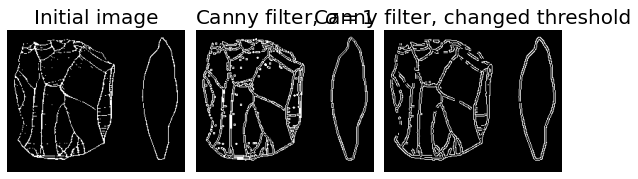

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage import feature


# Generate noisy image of a square
im = binary


# Compute the Canny filter for two values of sigma
edges1 = feature.canny(im,sigma=0.01,low_threshold=0.,high_threshold=0.2)
edges2 = feature.canny(im, sigma=1,low_threshold=0.85,high_threshold=1.0)

# display results
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(8, 3),
                                    sharex=True, sharey=True)

ax1.imshow(im, cmap=plt.cm.gray)
ax1.axis('off')
ax1.set_title('Initial image', fontsize=20)

ax2.imshow(edges1, cmap=plt.cm.gray)
ax2.axis('off')
ax2.set_title(r'Canny filter, $\sigma=1$', fontsize=20)

ax3.imshow(edges2, cmap=plt.cm.gray)
ax3.axis('off')
ax3.set_title(r'Canny filter, changed threshold', fontsize=20)

fig.tight_layout()

plt.show()

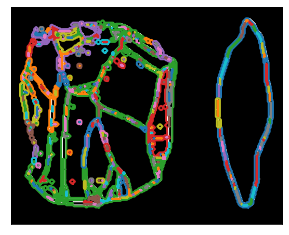

In [16]:
import numpy as np
import matplotlib.pyplot as plt

from skimage import measure



# Find contours at a constant value of 0.8
contours = measure.find_contours(edges1, 0.1,fully_connected='high')

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(edges2, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

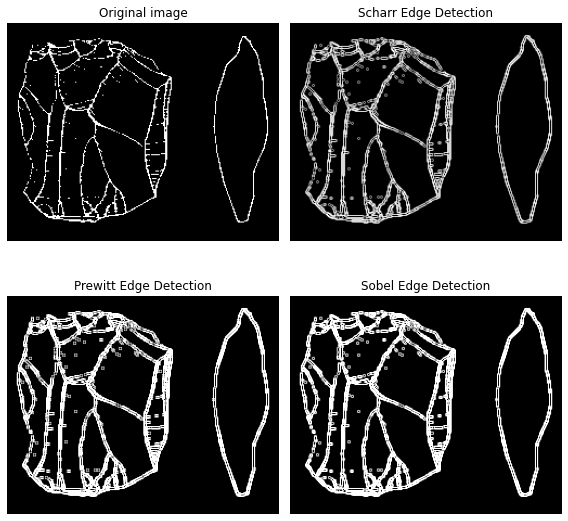

In [17]:
from skimage.util import compare_images
import numpy as np
# Creating a rotation-invariant image with different spatial frequencies.
image_rot = binary

edge_sobel = filters.sobel(image_rot)
edge_scharr = filters.scharr(image_rot)
edge_prewitt = filters.prewitt(image_rot)

diff_scharr_prewitt = compare_images(edge_scharr, edge_prewitt)
diff_scharr_sobel = compare_images(edge_scharr, edge_sobel)
max_diff = np.max(np.maximum(diff_scharr_prewitt, diff_scharr_sobel))

fig, axes = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True,
                         figsize=(8, 8))
axes = axes.ravel()

axes[0].imshow(image_rot, cmap=plt.cm.gray)
axes[0].set_title('Original image')

axes[1].imshow(edge_scharr, cmap=plt.cm.gray)
axes[1].set_title('Scharr Edge Detection')

axes[2].imshow(edge_prewitt, cmap=plt.cm.gray, vmax=max_diff)
axes[2].set_title('Prewitt Edge Detection')

axes[3].imshow(edge_sobel, cmap=plt.cm.gray, vmax=max_diff)
axes[3].set_title('Sobel Edge Detection')

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

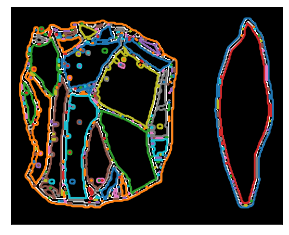

In [18]:
# Find contours at a constant value of 0.8
contours = measure.find_contours(edge_sobel, 0.1,fully_connected='low')

# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(edges2, cmap=plt.cm.gray)

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [19]:
new_countours = []
for cont in contours:
    if cont.shape[0]<80:
        continue
    else:
        new_countours.append(cont)
        
new_countours = np.array(new_countours)

/anaconda3/envs/vivarium_env/lib/python3.7/site-packages/ipykernel_launcher.py:8: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


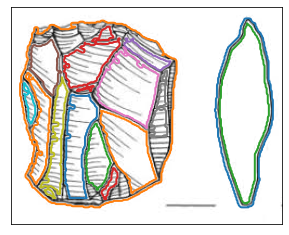

In [20]:
# Display the image and plot all contours found
fig, ax = plt.subplots()
ax.imshow(image, cmap=plt.cm.gray)

for contour in new_countours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [21]:
len(new_countours)

14